In [42]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings

warnings.filterwarnings('ignore')

In [43]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [44]:
batch_size = 32
img_height = 180
img_width = 180

In [45]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [46]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [47]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [48]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [49]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99028325


In [50]:
num_classes = len(class_names)

# VGG16

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 conv2d_53 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 conv2d_55 (Conv2D)          (None, 90, 90, 128)       147584    
                                                      

In [51]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 38s 349ms/step - loss: 1.5727 - accuracy: 0.2650 - val_loss: 1.4460 - val_accuracy: 0.3365
Epoch 2/10
92/92 [==============================] - 31s 341ms/step - loss: 1.3914 - accuracy: 0.3770 - val_loss: 1.3159 - val_accuracy: 0.4619
Epoch 3/10
92/92 [==============================] - 31s 334ms/step - loss: 1.2066 - accuracy: 0.4724 - val_loss: 1.1705 - val_accuracy: 0.5218
Epoch 4/10
92/92 [==============================] - 32s 346ms/step - loss: 1.1200 - accuracy: 0.5249 - val_loss: 1.0803 - val_accuracy: 0.5763
Epoch 5/10
92/92 [==============================] - 31s 341ms/step - loss: 1.0698 - accuracy: 0.5538 - val_loss: 1.0413 - val_accuracy: 0.5586
Epoch 6/10
92/92 [==============================] - 31s 341ms/step - loss: 1.0305 - accuracy: 0.5916 - val_loss: 1.0183 - val_accuracy: 0.5695
Epoch 7/10
92/92 [==============================] - 32s 347ms/step - loss: 1.0030 - accuracy: 0.6052 - val_loss: 1.0255 - val_accuracy: 0.5749

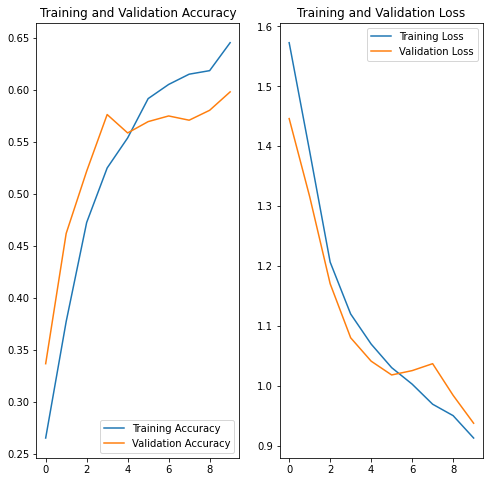

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()